In [ ]:
# import pickle

# filepath = "/Users/Data/Documents/DataScienceBootcamp/bostonmarathon/results/2014/results.pkl"
# with open(filepath, 'rb') as f:
#     pickled = pickle.load(f)
    
# pickled['35540']

In [35]:
# import cPickle
import _pickle as cPickle
import pickle
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib
import mpld3, mpld3.plugins
import numpy as np
from collections import Counter
from itertools import cycle
import pandas as pd
import seaborn as sns

import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

%matplotlib inline

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
# runners3 = cPickle.load("~/Documents/DataScienceBootcamp/bostonmarathon/results/2014/results.pkl")

#local environment
# runners = pd.read_csv("~/Documents/DataScienceBootcamp/bostonmarathon/results/2014/results.csv")

#interwebs
runners = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")

In [37]:
# Assigning column names

runners = runners[[
 '5k',
 '10k',
 '20k',
 'half',
 '25k',
 '30k',
 '35k',
 '40k',
 'official', #time overall
 'name',
 'division',   #mystery variable
 'gender',
 'age',
 'bib',  #ID number
 'genderdiv',  #ranking within gender class
 'ctz', # lots of NaNs - it's citizenship vs country of residence ('country') but many are missing
 'overall', #ranking overall
 'pace', #not really sure, could be approximate pace of each mile? roughly becomes 26.2 when 'official' divided by 'pace'
 'state',  #could group for US participants
 'country',  # could group by country
 'city']]


In [38]:
# Changing datatypes
runners = runners.replace(to_replace='-', value=np.nan)
runners['5k'] = runners['5k'].astype(float)
runners['10k'] = runners['10k'].astype(float)
runners['20k'] = runners['20k'].astype(float)
runners['half'] = runners['half'].astype(float)
runners['25k'] = runners['25k'].astype(float)
runners['30k'] = runners['30k'].astype(float)
runners['35k'] = runners['35k'].astype(float)
runners['40k'] = runners['40k'].astype(float)
runners['official'] = runners['official'].astype(float)
runners['age'] = runners['age'].astype(int)
runners['gender'] = runners['gender'].apply(lambda x: 1 if x == 'M' else 0) # males 1, females 0
runners['country'] = runners['country'].astype('category')
runners['CtyCode'] = runners['country'].cat.codes

In [39]:
runners.shape

(31984, 22)

In [40]:
runners.dtypes

5k            float64
10k           float64
20k           float64
half          float64
25k           float64
30k           float64
35k           float64
40k           float64
official      float64
name           object
division        int64
gender          int64
age             int64
bib            object
genderdiv       int64
ctz            object
overall         int64
pace          float64
state          object
country      category
city           object
CtyCode          int8
dtype: object

In [41]:
#ditches NAs and variables with string data, as well as the overall column which TopGroup is based on
runners = runners.drop(['name', 'state', 'ctz', 'division', 'bib', 'city', 
                        'country', 
                        'official', # this is their official time which is directly related to overall ranking
                        'pace'], axis=1) # add country back in

top_runners = runners.overall.quantile(0.2)
top_runners

# 1 if in Top 20% of rankings overall, not separated by gender, 0 if in bottom 80%
runners['TopGroup'] = runners.overall.apply(lambda x: 1 if x <= top_runners else 0)

runners = runners.dropna()

runners = runners.drop(['overall'], axis=1)
runners.shape

(31649, 13)

In [42]:
print(list(runners))

['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'gender', 'age', 'genderdiv', 'CtyCode', 'TopGroup']


In [43]:
#Split into X and y groups
y = runners['TopGroup']
X = runners.drop('TopGroup', axis=1)

In [44]:
### Normalize the data

# Normalize the data.
X_norm = normalize(X)

In [45]:
### Reduce dimensions

MySpecialPCA = PCA(n_components=2)

# Reduce it to two components.
X_pca = MySpecialPCA.fit_transform(X_norm)

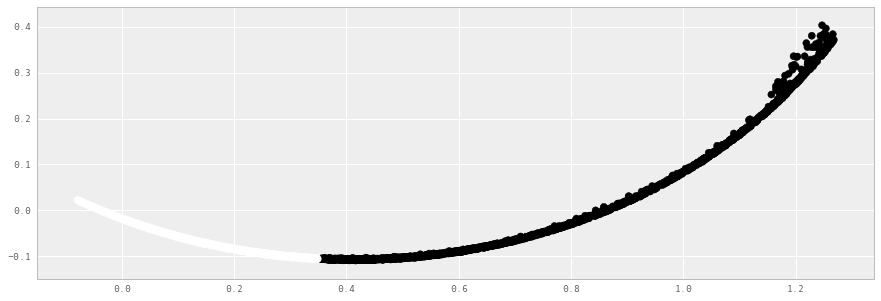

Comparing k-means clusters against the data:
col_0        0     1
Actuals             
0        25266     0
1         5116  1267


In [46]:
### K-Means

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y, y_pred, rownames=["Actuals"]))

In [23]:
MySpecialPCA.components_

i = np.identity(X.shape[1])

coef = MySpecialPCA.transform(i)

factor_loadings = pd.DataFrame(coef, columns=['PC-1', 'PC-2'], index=X.columns)

factor_loadings.sort_values(by='PC-1', ascending=False)

,PC-1,PC-2
40k,0.872564,0.605835
35k,0.813805,0.646474
30k,0.753650,0.679883
25k,0.694858,0.712537
half,0.650451,0.738876
20k,0.638198,0.746679
CtyCode,0.616417,0.835526
10k,0.525154,0.814406
age,0.513007,0.873392
5k,0.469474,0.850389


Number of estimated clusters: 6


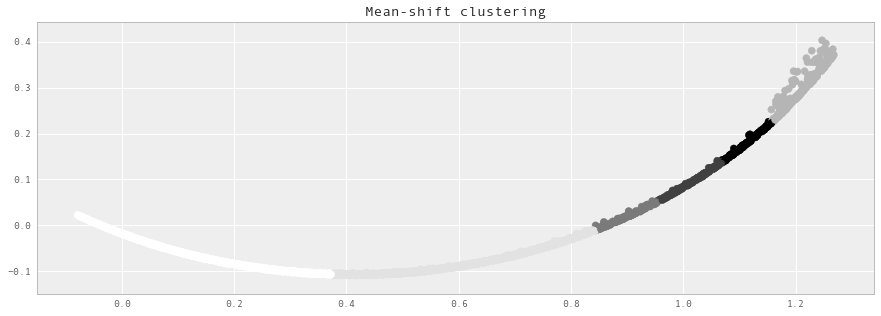

Comparing the assigned categories to the ones in the data:
col_0         0    1    2    3    4   5
TopGroup                               
0         25266    0    0    0    0   0
1          5176  756  163  108  101  79

2.614955358993029


In [30]:
### Meanshift Method

km_start = timer()

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=200)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
# print(pd.crosstab(y_train, ms))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title("Mean-shift clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y,labels))

km_end = timer()
print('')
print(km_end - km_start)

In [32]:
### Spectral Clustering

sc_start = timer()

# Declare and fit the model.
sc = SpectralClustering(n_clusters=2)

#Predicted clusters.
predict=sc.fit_predict(X_pca)

#Graph results.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict)
plt.title("Spectral clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y, predict))

sc_end = timer()
print(sc_end - sc_start) 

KeyboardInterrupt: 

In [ ]:
### Affinity Propogation


# ap_start = timer()

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_pca)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

# ap_end = timer()
# print(ap_end - ap_start) 

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propogation Clustering with {} estimated number of clusters'.format(n_clusters_))
plt.show()


## Experimenting with code. Disregard.

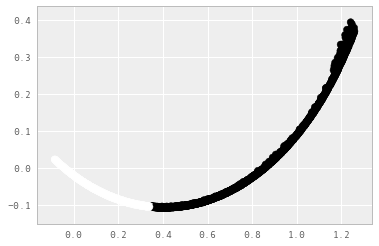

Number of estimated clusters: 2
Comparing the assigned categories to the ones in the data:
col_0        0     1
TopGroup            
0         1453  1088
1            0   623
0.5780605760082835


/usr/local/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [382]:
from timeit import default_timer as timer

start = timer()

from sklearn.model_selection import train_test_split

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

# print('Comparing the assigned categories to the ones in the data:')
# print(pd.crosstab(centers,y))

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
# print('Comparing k-means clusters against the data:')
# print(pd.crosstab(y_pred, y))




from sklearn.cluster import MeanShift, estimate_bandwidth
km_start = timer()

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
# bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=50)

# Declare and fit the model.
ms = MeanShift(bandwidth=None, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))
# print(pd.crosstab(y_train, ms))

# plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
# plt.title("Mean-shift clustering")
# plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

km_end = timer()
print(km_end - km_start) 




from sklearn.cluster import SpectralClustering

sc_start = timer()

n_clusters=4

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.title("Spectral clustering")
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

sc_end = timer()
print(sc_end - sc_start) 




from sklearn.cluster import AffinityPropagation
from sklearn import metrics

ap_start = timer()

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

ap_end = timer()
print(ap_end - ap_start) 

from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Affinity Propogation Clustering with {} estimated number of clusters'.format(n_clusters_))
plt.show()

end = timer()
print(end - start) 

In [215]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

# The coordinates of the centers of our blobs.
centers = [[2, 2], [-2, -2], [2, -2]

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

# print('Comparing the assigned categories to the ones in the data:')
# print(pd.crosstab(centers,y))

SyntaxError: invalid syntax (<ipython-input-215-caa4a6e26ec9>, line 9)

In [216]:
pd.qcut(runners['overall'], [.1, .25, .5, .75])

KeyError: 'overall'

In [218]:
### look at ranking at mid-point compared to official/final time

### 

In [219]:
runners.Average = runners.official / runners.pace
#85.25


AttributeError: 'DataFrame' object has no attribute 'pace'

In [220]:
runners.bib.value_counts()
len(runners.bib.unique())
runners.division.value_counts()

AttributeError: 'DataFrame' object has no attribute 'bib'

In [221]:
# runners["1"]
runners.head()
list(runners)
runners.shape
runners.dtypes
runners.describe().round(2)
list(runners)

]

SyntaxError: invalid syntax (<ipython-input-221-0a8b5cf852b0>, line 9)

In [222]:
def bar(xs, ys):
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, axisbg='#EEEEEE')
    ax.grid(color='white', linestyle='solid')
    ax.bar(xs, ys, fc='lightblue', alpha=0.8, edgecolor="white")

In [223]:
ages = Counter(int(x['age']) for x in runners.itervalues())
xs = range(min(ages.keys()), max(ages.keys()))
ys = [ages[i] for i in xs]
bar(xs, ys)
mpld3.display()

AttributeError: 'DataFrame' object has no attribute 'itervalues'

In [224]:
from collections import Counter
men = Counter(int(x['age']) for x in runners.itervalues() if x['gender']=="M")
mxs = range(min(men.keys()), max(men.keys()))
mys = [men[i] for i in mxs]

wmn = Counter(int(x['age']) for x in runners.itervalues() if x['gender']=="F")
wxs = range(min(wmn.keys()), max(wmn.keys()))
wys = [wmn[i] for i in wxs]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, axisbg='#EEEEEE', title="2013 Boston Marathon participants, by age and gender")
ax.grid(color='white', linestyle='solid')
b1 = ax.bar(mxs, mys, color='lightblue', alpha=1, edgecolor="white", label="Men")
b2 = ax.bar(wxs, wys, color='pink', alpha=0.6, edgecolor="white", label="Women")
ax.legend()

mpld3.display()

AttributeError: 'DataFrame' object has no attribute 'itervalues'

In [225]:
def minutes(time):
    parts = [int(x) for x in runners[105]['official'].split(':')]
    return parts[0] * 60 + parts[1] + parts[2]/60.

In [226]:
r2014 = cPickle.load(file("results/2014/results.pkl"))

NameError: name 'cPickle' is not defined

In [227]:
len(r2014)

NameError: name 'r2014' is not defined

In [228]:
r2014["30592"]

NameError: name 'r2014' is not defined

In [229]:
from collections import Counter
men = Counter(int(x['age']) for x in r2014.itervalues() if x['gender']=="M")
mxs = range(min(men.keys()), max(men.keys()))
mys = [men[i] for i in mxs]

wmn = Counter(int(x['age']) for x in r2014.itervalues() if x['gender']=="F")
wxs = range(min(wmn.keys()), max(wmn.keys()))
wys = [wmn[i] for i in wxs]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, axisbg='#EEEEEE', title="2014 Boston Marathon participants, by age and gender")
ax.grid(color='white', linestyle='solid')
b1 = ax.bar(mxs, mys, color='lightblue', alpha=1, edgecolor="white", label="Men")
b2 = ax.bar(wxs, wys, color='pink', alpha=0.6, edgecolor="white", label="Women")
ax.legend()

mpld3.display()

NameError: name 'r2014' is not defined

In [230]:
df = pd.read_csv("results/2014/results.csv")

In [231]:
df.head(10)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72
5,32.58,"Sumgong, Jemima Jelagat",4,82.45,F,29,140.68,F3,4,NaN,...,28,5.37,NaN,99.33,16.22,69.47,65.83,KEN,Nandi,132.95
6,17.65,"Hug, Marcel E.",4,47.67,M,28,84.65,W4,4,NaN,...,4,3.23,NaN,58.60,8.38,39.72,37.65,SUI,Neuenkirch,79.83
7,30.48,"Geneti, Markos",5,76.95,M,29,129.83,5,5,NaN,...,5,4.97,NaN,92.52,15.17,64.85,61.62,ETH,Addis Ababa,122.80
8,17.12,"Soejima, Masazumi",3,46.37,M,43,81.23,W6,3,NaN,...,3,3.10,NaN,57.03,8.00,38.60,36.60,JPN,Isahaya,76.70
9,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,NaN,...,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83


In [232]:
df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


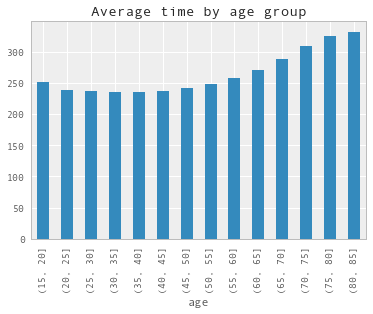

In [233]:
df['official'].groupby(pd.cut(df['age'], range(15,90,5))).aggregate(np.average).plot(kind="bar", title="Average time by age group")

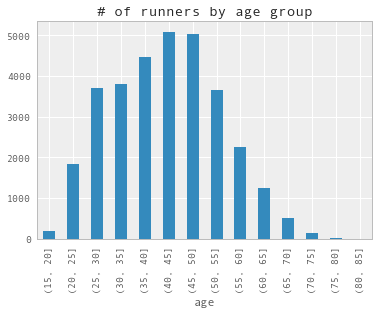

In [234]:
df['official'].groupby(pd.cut(df['age'], range(15,90,5))).aggregate(len).plot(kind="bar", title="# of runners by age group")

CategoricalIndex(['15-20', '15-20', '15-20', '15-20', '15-20', '15-20',
                  '15-20', '20-25', '20-25', '20-25', '20-25', '20-25',
                  '20-25', '20-25', '20-25', '25-30', '25-30', '25-30',
                  '25-30', '25-30', '25-30', '25-30', '25-30', '30-35',
                  '30-35', '30-35', '30-35', '30-35', '30-35', '30-35',
                  '30-35', '35-40', '35-40', '35-40', '35-40', '35-40',
                  '35-40', '35-40', '35-40', '40-45', '40-45', '40-45',
                  '40-45', '40-45', '40-45', '40-45', '40-45', '45-50',
                  '45-50', '45-50', '45-50', '45-50', '45-50', '45-50',
                  '45-50', '50-55', '50-55', '50-55', '50-55', '50-55',
                  '50-55', '50-55', '55-60', '55-60', '55-60', '55-60',
                  '55-60', '55-60', '55-60', '60-65', '60-65', '60-65',
                  '60-65', '60-65', '60-65', '60-65', '65-70', '65-70',
                  '65-70', '65-70', '65-70', '65-70', '70-75', '

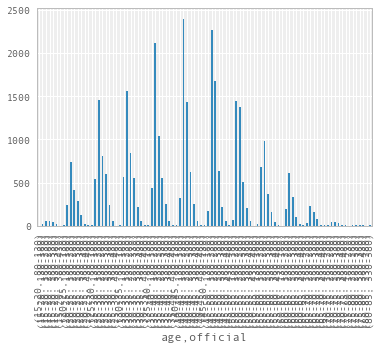

In [235]:
#Q: What's the distribution of finish times *within* an age group... small multiples
agegroups = range(15,90,5)
agebins = pd.cut(df['age'], agegroups,
                 labels=['{}-{}'.format(age,age+5) for age in agegroups][:-1])
times = range(80, 530, 50)
timebins = pd.cut(df['official'], times,
                  labels=['{}-{}'.format(t, t+50) for t in times][:-1])
age_and_time = df['official'].groupby([agebins, timebins]).aggregate(len)
#age_and_time = age_and_time.to_frame()
age_and_time.plot(kind="bar")
age_and_time.index.get_level_values(0)
#age_and_time["(15, 20]"]
#x = [age_and_time[ax] for ax in age_and_time.axes[0].levels[0]]
#x[0].values

In [236]:
pd.cut?

In [237]:
years = []
for year in range(2001, 2015):
    y = pd.read_csv("results/{}/results.csv".format(year), na_values="-")[["official", "gender", "age"]]
    y["year"] = str(year)
    years.append(y)
alltimes = pd.concat(years, ignore_index=True).dropna()

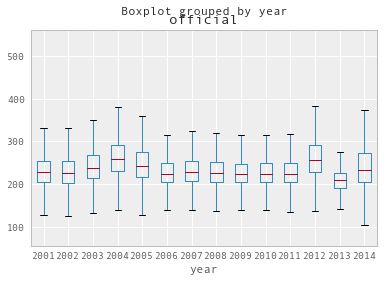

In [238]:
plt.figure()
alltimes.boxplot(column='official', by='year')

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


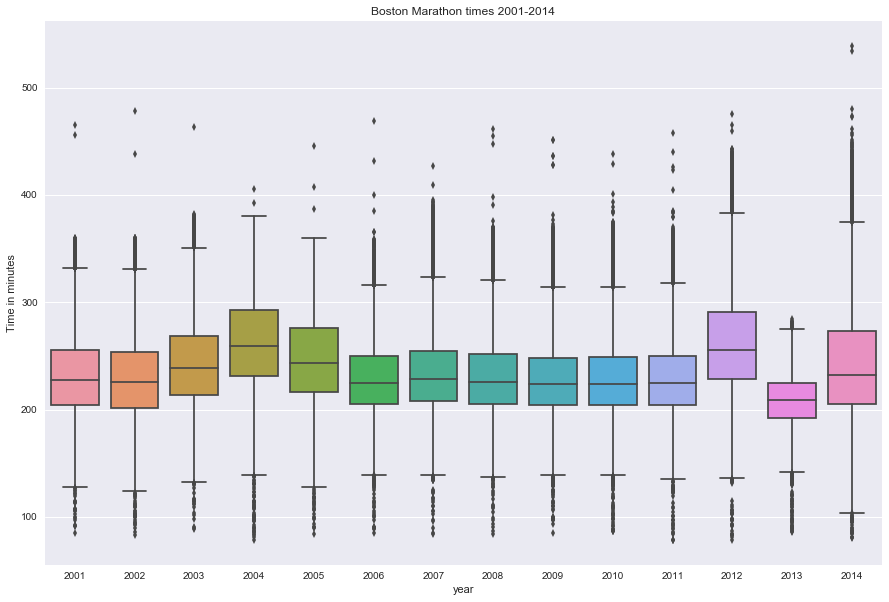

In [239]:
seaborn.set(context = 'notebook', style = 'darkgrid')
# not sure how to do this non-globally?
seaborn.set_context(rc={"figure.figsize": (15, 10)})

f, ax1 = plt.subplots(1)
ax1.set_title("Boston Marathon times 2001-2014")
seaborn.boxplot(pd.Series(alltimes.loc[:, "official"], name="Time in minutes"), groupby=alltimes.year)

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


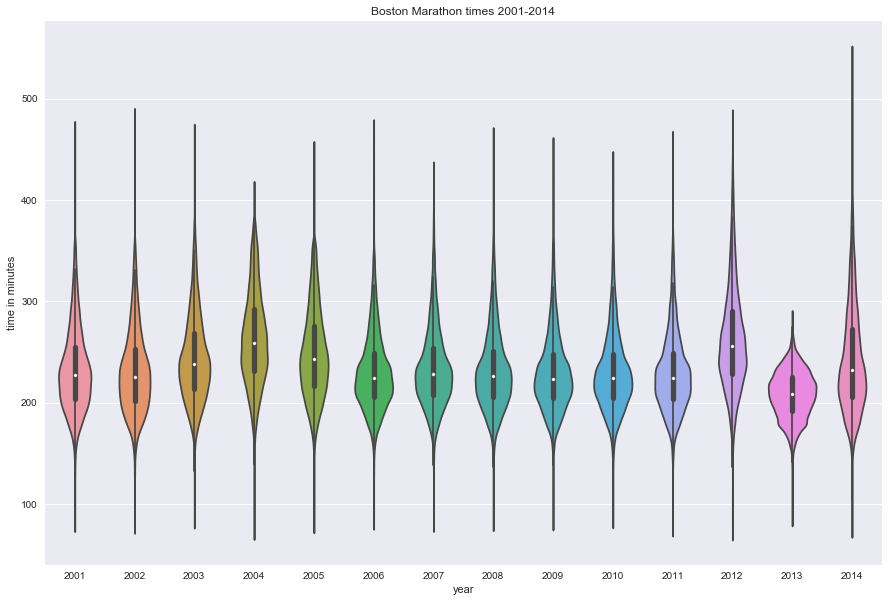

In [240]:
f, ax1 = plt.subplots(1)
ax1.set_title("Boston Marathon times 2001-2014")
seaborn.violinplot(pd.Series(alltimes.loc[:, "official"], name="time in minutes"), groupby=alltimes.year, ax=ax1)

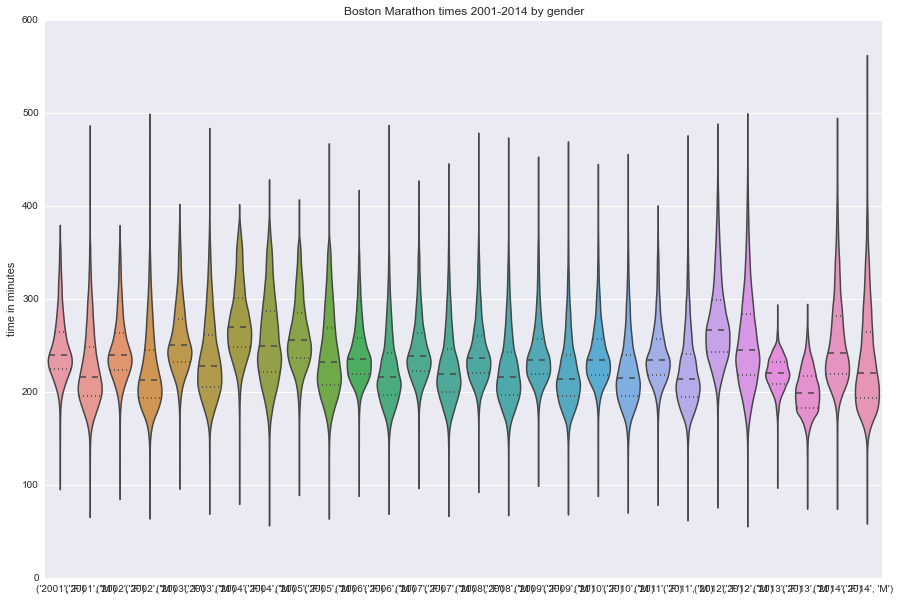

In [132]:
f, ax1 = plt.subplots(1)
ax1.set_title("Boston Marathon times 2001-2014 by gender")
seaborn.violinplot(pd.Series(alltimes.loc[:, "official"], name="time in minutes"), groupby=[alltimes.year, alltimes.gender], ax=ax1)

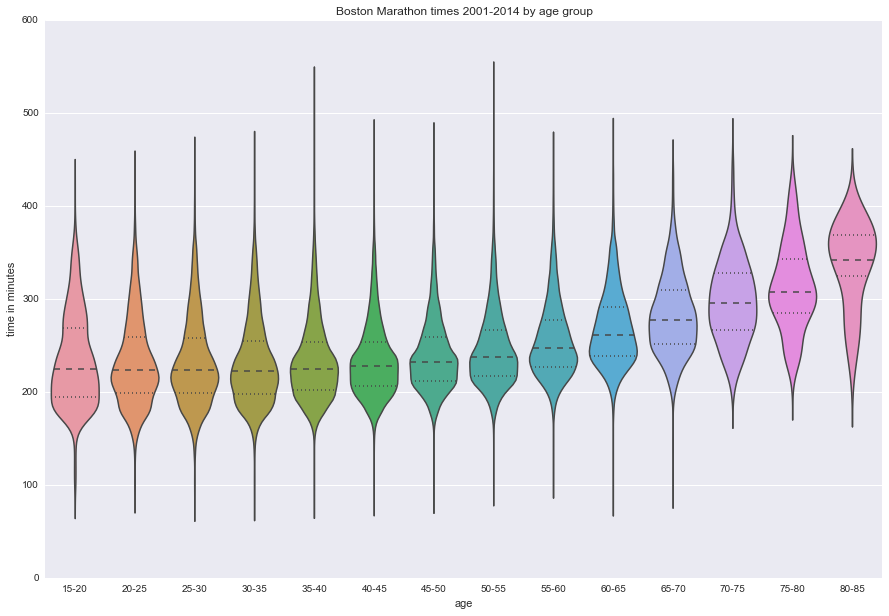

In [144]:
# wow that is a hideous, useless plot. Looks like women finish a predictable amount worse than men every year?
# I wonder how, across all years, age groups do. (That one might benefit from a gender split, more than the above)
# Also TODO: a map of the states & countries of Boston Marathon participants

alltimes
agegroups = range(15,90,5)
agebins = pd.cut(alltimes['age'], agegroups,
                 labels=['{}-{}'.format(age,age+5) for age in agegroups][:-1])

f, ax1 = plt.subplots(1)
ax1.set_title("Boston Marathon times 2001-2014 by age group")
seaborn.violinplot(pd.Series(alltimes.loc[:, "official"], name="time in minutes"), groupby=agebins, ax=ax1)

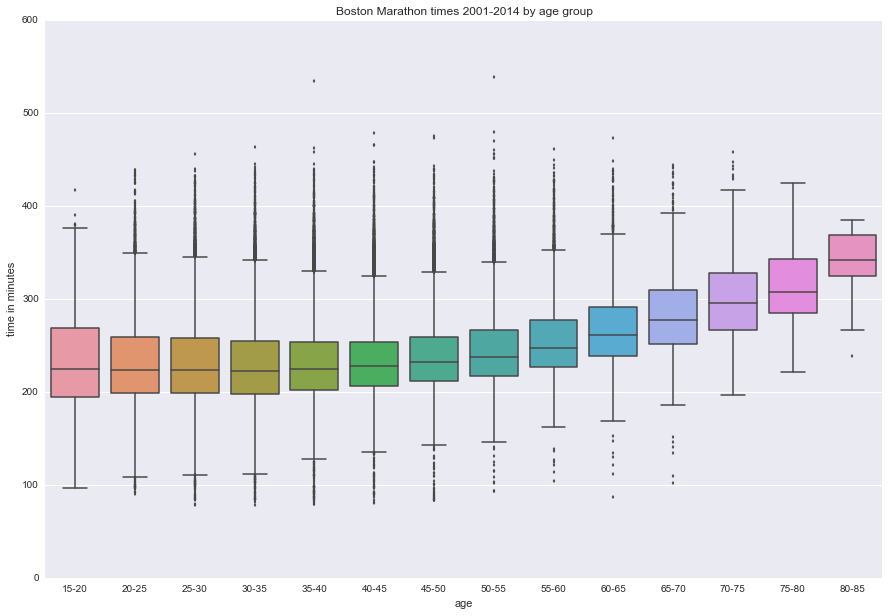

In [154]:
# wow that is a hideous, useless plot. Looks like women finish a predictable amount worse than men every year?
# I wonder how, across all years, age groups do. (That one might benefit from a gender split, more than the above)
# Also TODO: a map of the states & countries of Boston Marathon participants

alltimes
agegroups = range(15,90,5)
agebins = pd.cut(alltimes['age'], agegroups,
                 labels=['{}-{}'.format(age,age+5) for age in agegroups][:-1])

f, ax1 = plt.subplots(1)
ax1.set_title("Boston Marathon times 2001-2014 by age group")
seaborn.boxplot(pd.Series(alltimes.loc[:, "official"], name="time in minutes"), groupby=agebins, ax=ax1)

### # wow that is a hideous, useless plot. Looks like women finish a predictable amount worse than men every year? # I wonder how, across all years, age groups do. (That one might benefit from a gender split, more than the above) # Also TODO: a map of the states & countries of Boston Marathon participants  alltimes agegroups = range(15,90,5) agebins = pd.cut(alltimes['age'], agegroups,                  labels=['{}-{}'.format(age,age+5) for age in agegroups][:-1])  f, ax1 = plt.subplots(1) ax1.set_title("Boston Marathon times 2001-2014 by age group") seaborn.violinplot(pd.Series(alltimes.loc[:, "official"], name="time in minutes"), groupby=[alltimes.gender, agebins], ax=ax1) g = alltimes.groupby([agebins, alltimes.gender]) g.head()

In [167]:
years = []
for year in range(2001, 2015):
    y = pd.read_csv("results/{}/results.csv".format(year), na_values="-")[["state"]]
    years.append(y)
states = pd.concat(years, ignore_index=True).dropna()
g = states.groupby("state") #.aggregate(len)
h = g.count()


In [170]:
import json
json.dumps(h.to_dict()['state'])

'{"WA": 4882, "BC": 2914, "VA": 6611, "DE": 739, "DC": 1595, "WI": 4591, "WV": 474, "HI": 543, "CO": 5111, "FL": 6676, "FM": 2, "WY": 249, "NH": 4469, "SK": 350, "NJ": 5860, "PQ": 1344, "NL": 96, "NM": 720, "TX": 9662, "LA": 734, "NB": 679, "NC": 4737, "ND": 296, "NE": 837, "NF": 113, "YT": 23, "TN": 2407, "NY": 15299, "PA": 9399, "PE": 194, "NS": 1102, "NT": 13, "CA": 19467, "NV": 850, "AA": 12, "PR": 374, "GU": 7, "AB": 2338, "AE": 75, "PW": 1, "ON": 11940, "VI": 27, "AK": 554, "OH": 8111, "AL": 1028, "AP": 19, "AS": 1, "AR": 567, "VT": 1443, "IL": 10158, "GA": 3682, "IN": 3009, "IA": 1693, "OK": 898, "AZ": 2686, "ID": 873, "CT": 5082, "ME": 2222, "MD": 4941, "MA": 58667, "MB": 437, "UT": 3240, "MO": 2298, "MN": 5102, "MI": 7184, "RI": 1968, "KS": 1491, "MT": 563, "QC": 1527, "MS": 395, "SC": 1532, "KY": 1399, "OR": 3160, "SD": 269}'

In [172]:
dict(sorted(h.to_dict().iteritems()))

{'state': {'AA': 12,
  'AB': 2338,
  'AE': 75,
  'AK': 554,
  'AL': 1028,
  'AP': 19,
  'AR': 567,
  'AS': 1,
  'AZ': 2686,
  'BC': 2914,
  'CA': 19467,
  'CO': 5111,
  'CT': 5082,
  'DC': 1595,
  'DE': 739,
  'FL': 6676,
  'FM': 2,
  'GA': 3682,
  'GU': 7,
  'HI': 543,
  'IA': 1693,
  'ID': 873,
  'IL': 10158,
  'IN': 3009,
  'KS': 1491,
  'KY': 1399,
  'LA': 734,
  'MA': 58667,
  'MB': 437,
  'MD': 4941,
  'ME': 2222,
  'MI': 7184,
  'MN': 5102,
  'MO': 2298,
  'MS': 395,
  'MT': 563,
  'NB': 679,
  'NC': 4737,
  'ND': 296,
  'NE': 837,
  'NF': 113,
  'NH': 4469,
  'NJ': 5860,
  'NL': 96,
  'NM': 720,
  'NS': 1102,
  'NT': 13,
  'NV': 850,
  'NY': 15299,
  'OH': 8111,
  'OK': 898,
  'ON': 11940,
  'OR': 3160,
  'PA': 9399,
  'PE': 194,
  'PQ': 1344,
  'PR': 374,
  'PW': 1,
  'QC': 1527,
  'RI': 1968,
  'SC': 1532,
  'SD': 269,
  'SK': 350,
  'TN': 2407,
  'TX': 9662,
  'UT': 3240,
  'VA': 6611,
  'VI': 27,
  'VT': 1443,
  'WA': 4882,
  'WI': 4591,
  'WV': 474,
  'WY': 249,
  'YT': 23

In [173]:
years = []
for year in range(2001, 2015):
    y = pd.read_csv("results/{}/results.csv".format(year), na_values="-")[["country"]]
    years.append(y)
states = pd.concat(years, ignore_index=True).dropna()
g = states.groupby("country") #.aggregate(len)
h = g.count()

In [174]:
json.dumps(h.to_dict()['country'])

'{"LIE": 1, "EGY": 3, "LIB": 2, "QAT": 4, "PAR": 2, "BOL": 3, "SIN": 98, "PAN": 17, "PRK": 1, "TAN": 2, "UAE": 34, "HKG": 211, "HAI": 2, "TPE": 19, "SVK": 29, "CHI": 172, "MAS": 14, "CHN": 79, "URU": 16, "JAM": 8, "SUI": 474, "ZIM": 5, "FIN": 99, "THA": 3, "PHI": 13, "MAR": 8, "AHO": 4, "LAT": 7, "KAZ": 1, "GUA": 57, "BEL": 220, "CRC": 142, "KSA": 7, "DEN": 312, "BER": 191, "CMR": 5, "GER": 1778, "ROM": 7, "SCG": 1, "ROU": 2, "TCA": 1, "TRI": 11, "VGB": 3, "BLR": 2, "GRE": 103, "ANG": 1, "MON": 1, "IND": 17, "INA": 1, "NOR": 86, "CZE": 30, "ESA": 17, "DOM": 31, "LUX": 19, "ISR": 44, "NED": 286, "PER": 68, "ISL": 154, "ETH": 63, "COL": 151, "NEP": 1, "SER": 1, "ECU": 89, "FRA": 707, "LTU": 8, "TWN": 7, "AUS": 639, "GBR": 1837, "AUT": 165, "VEN": 145, "KEN": 145, "TUR": 12, "ITA": 1168, "BRN": 1, "TUN": 1, "RUS": 92, "MEX": 1414, "BRA": 481, "CAY": 21, "BAR": 3, "NGR": 1, "USA": 240937, "SWE": 222, "UKR": 9, "CAN": 23070, "KOR": 1489, "BAH": 20, "CYP": 1, "POR": 93, "CRO": 6, "POL": 109,